In [5]:
!pip install scikit-plot

In [0]:
import random
import numpy as np
import torch
import torchvision
from  torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torchvision import datasets, transforms
from torchsummary import summary
from keras.preprocessing import sequence
import os
import skimage
from collections import Counter

In [0]:
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
from nltk.corpus import stopwords

from torchtext import data
from torchtext.vocab import Vectors
from torch.nn import init
from tqdm import tqdm

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred,normalize=False)
    plt.show()

In [0]:
class nn_Fake_News(nn.Module):
    def __init__(self):
        super(nn_Fake_News, self).__init__()
        self.embedding = nn.Embedding(5002, 10)
        self.lstm = nn.LSTM(300, 150, 1, bidirectional=False)
        self.drop = nn.Dropout(0.7)
        self.relu = nn.ReLU()
        self.nn_linear1 = nn.Linear(150, 2)
        self.output = nn.Sigmoid()

    def forward(self, input):
        x = self.embedding(input)
        x = self.drop(x)
        x = x.reshape(input.shape[0], 10, 300)
        x,_ = self.lstm(x)
        x = self.relu(x)
        x = torch.sum(x, axis=1)
        x = x.reshape(input.shape[0], 150)
        x = self.drop(x)
        x = self.nn_linear1(x)  
        return x

In [0]:
xtr = np.load('./xtr_shuffled.npy', allow_pickle=True)
xte = np.load('./xte_shuffled.npy', allow_pickle=True)
ytr = np.load('./ytr_shuffled.npy', allow_pickle=True)
yte = np.load('./yte_shuffled.npy', allow_pickle=True)

In [0]:
cnt = Counter()
top_words = 5000
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  

most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

y_train = list(ytr)
y_test = list(yte)

i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

x_test = []
for x in xte:
    x_test.append(x.split())

for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

max_review_length = 300
xtr = sequence.pad_sequences(x_train, maxlen=max_review_length)
xte = sequence.pad_sequences(x_test, maxlen=max_review_length)

ytr = np.array(y_train)
yte = np.array(y_test)

In [0]:
tr_label = np.zeros((xtr.shape[0], 2), dtype=float)
for i in range(xtr.shape[0]):
  if ytr[i] == 1:
    tr_label[i, :] = [0.0, 1.0]
  else:
    tr_label[i, :] = [1.0, 0.0]
tr_label = torch.from_numpy(tr_label).double().cuda()

In [44]:
nn_FN = nn_Fake_News().double().cuda()
optimizer = optim.SGD(nn_FN.parameters(), lr=0.01, momentum=0.9)

loss_function = nn.BCEWithLogitsLoss()

for epoch in range(50):  
  for i in range(160):
    y_pred = nn_FN(torch.from_numpy(xtr[i*100:i*100+100,:]).reshape([100,300]).long().cuda())
    optimizer.zero_grad()
    loss = loss_function(y_pred, tr_label[i*100:i*100+100, :].detach()) * 50
    
    loss.backward()
    optimizer.step()        

  #print("Loss = %.5f" % loss.item()) 
  if (epoch%1==0):
    print("Epoch %d" % epoch)
    print("Loss = %.5f" % (loss.item())) 
    torch.save(nn_FN, 'nn_Fake_News.pkl')
    y_pred_raw =torch.zeros((2000,2)).cuda()
    for i in range(20):
     y_pred_raw[i*100:i*100+100,:] = nn_FN(torch.from_numpy(xte[i*100:i*100+100,:]).long().cuda())
    y_pred = np.zeros(2000, dtype=int)
    for i in range(y_pred_raw.shape[0]):
      if y_pred_raw[i, 1] > y_pred_raw[i, 0]:
       y_pred[i] = 1
      else:
       y_pred[i] = 0
    m = 2000
    n = (yte[:2000] != y_pred).sum()
    print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 72.94%

print('Finished Training')

Epoch 0
Loss = 36.20254
Accuracy = 61.35%
Epoch 1
Loss = 31.07855
Accuracy = 69.25%
Epoch 2
Loss = 23.31109
Accuracy = 75.45%
Epoch 3
Loss = 22.43194
Accuracy = 78.60%
Epoch 4
Loss = 18.66550
Accuracy = 80.90%
Epoch 5
Loss = 19.32229
Accuracy = 81.65%
Epoch 6
Loss = 22.92108
Accuracy = 82.55%
Epoch 7
Loss = 18.81836
Accuracy = 84.00%
Epoch 8
Loss = 18.03704
Accuracy = 83.70%
Epoch 9
Loss = 14.50788
Accuracy = 85.75%
Epoch 10
Loss = 19.08966
Accuracy = 87.10%
Epoch 11
Loss = 11.90081
Accuracy = 86.50%
Epoch 12
Loss = 14.14993
Accuracy = 87.30%
Epoch 13
Loss = 16.97785
Accuracy = 86.05%
Epoch 14
Loss = 13.26905
Accuracy = 86.35%
Epoch 15
Loss = 11.63268
Accuracy = 87.70%
Epoch 16
Loss = 12.70757
Accuracy = 87.80%
Epoch 17
Loss = 10.07502
Accuracy = 88.35%
Epoch 18
Loss = 10.78401
Accuracy = 88.25%
Epoch 19
Loss = 11.43120
Accuracy = 87.65%
Epoch 20
Loss = 10.10199
Accuracy = 88.15%
Epoch 21
Loss = 14.16342
Accuracy = 89.05%
Epoch 22
Loss = 11.92989
Accuracy = 89.65%
Epoch 23
Loss = 11.99

Accuracy = 90.22%


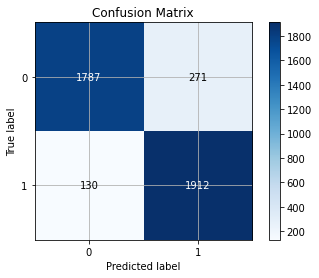

In [46]:
y_pred_raw =torch.zeros((4100,2)).cuda()
for i in range(41):
     y_pred_raw[i*100:i*100+100,:] = nn_FN(torch.from_numpy(xte[i*100:i*100+100,:]).long().cuda())

y_pred = np.zeros(4100, dtype=int)
for i in range(y_pred_raw.shape[0]):
    if y_pred_raw[i, 1] > y_pred_raw[i, 0]:
      y_pred[i] = 1
    else:
      y_pred[i] = 0

m = 4100
n = (yte[:4100] != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 72.94%
# Draw the confusion matrix
plot_cmat(yte[:4100], y_pred)

In [16]:
print(sum(param.numel() for param in nn_FN.parameters()))

321522
